__Purpose:__ Introduce Federated Learning, specifically by implementing FedAveraging on our dataset and moving on to more advanced methods.  Start by modifying the Simulations code, worry about (a)synchronicity later.
<br>
1. The dec matrix is the weights to pass back an forth (I think), although it comes out of SmoothBatch first
1. We are assuming we can test on the second half (updates 10-19ish) since learning should be complete by then!
1. Scipy.optimize.minimize() runs many iters to fully minimize its cost function.  You can change it to run as many iters as you'd like, although AFAIK you won't know how many it takes to converge.  But this is still a good set up for FL.
1. Hmm minimize() is doing BFGS rn and not SGD... not sure if that matters really.  Could probably implement SGD on my own or find it.  BFGS is 2nd order but we don't have a lot of parameters, I don't think.  Plus we can (already have?) solved analytically for the Hessian.

In [1]:
import pandas as pd
import os
import numpy as np
import random
from matplotlib import pyplot as plt
from scipy.optimize import minimize, least_squares
import copy
from itertools import permutations

In [2]:
from experiment_params import *
from simulations import *
import time
import pickle

In [3]:
path = r'C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\Data'
cond0_filename = r'\cond0_dict_list.p'
id2color = {0:'lightcoral', 1:'maroon', 2:'chocolate', 3:'darkorange', 4:'gold', 5:'olive', 6:'olivedrab', 
            7:'lawngreen', 8:'aquamarine', 9:'deepskyblue', 10:'steelblue', 11:'violet', 12:'darkorchid', 13:'deeppink'}
implemented_client_training_methods = ['EtaGradStep', 'EtaScipyMinStep', 'FullScipyMinStep']

# Reminder of Conditions Order

NOTE: 

* **CONDITIONS** = array(['D_1', 'D_2', 'D_5', 'D_6', 'D_3', 'D_4', 'D_7','D_8']
* **LEARNING RATES:** alpha = 0.25 and 0.75; alpha = 0.25 for D1, D2, D5, D6; alpha = 0.75 for D3, D4, D7, D8
* **SMOOTHBATCH:** W_next = alpha*W_old + ((1 - alpha) * W_calc)

* **DECODER INIT:** pos for D1 - D4, neg for D5 - D8

* **PENALTY TERM:** $\lambda_E$ = 1e-6 for all, $\lambda_F$ = 1e-7 for all, $\lambda_D$ = 1e-3 for 1, 3, 5, 7 and 1e-4 for 2, 4, 6, 8 


| DECODER | ALPHA | PENALTY | DEC INIT |
| --- | --- | --- | --- |
| 1 | 0.25 | 1e-3 | + |
| 2 | 0.25 | 1e-4 | + |
| 3 | 0.75 | 1e-3 | + |
| 4 | 0.75 | 1e-4 | + |
| 5 | 0.25 | 1e-3 | - |
| 6 | 0.25 | 1e-4 | - |
| 7 | 0.75 | 1e-3 | - |
| 8 | 0.75 | 1e-4 | - |


## Load Our Data In

In [4]:
#t0 = time.time()

#with open('Data\continuous_full_data_block1.pickle', 'rb') as handle:
#    #refs_block1, poss_block1, dec_vels_block1, int_vel_block1, emgs_block1, Ws_block1, Hs_block1, alphas_block1, pDs_block1, times_block1, conditions_block1 = pickle.load(handle)
#    refs_block1, _, _, _, emgs_block1, Ws_block1, _, _, _, _, _ = pickle.load(handle)

#with open('Data\continuous_full_data_block2.pickle', 'rb') as handle:
#    #refs_block2, poss_block2, dec_vels_block2, int_vel_block2, emgs_block2, Ws_block2, Hs_block2, alphas_block2, pDs_block2, times_block2, conditions_block2 = pickle.load(handle)
#    #refs_block2, _, _, _, emgs_block2, Ws_block2, _, _, _, _, _ = pickle.load(handle)

#t1 = time.time()
#total = t1-t0  
#print(total)

In [5]:
'''
list_length = 14
cond0_dict_list = [0]*list_length
for idx in range(list_length):
    cond0_dict_list[idx] = {'training':emgs_block1[keys[idx]][0,:,:], 'labels':refs_block1[keys[idx]][0,:,:]}

with open(path+cond0_filename, 'wb') as fp:
    pickle.dump(cond0_dict_list, fp, protocol=pickle.HIGHEST_PROTOCOL)
'''
0

0

# Create Federated Set Up

In [6]:
# python src/emg_fl_main.py --num_users=14, --model=___, --dataset=___, --num_classes=___, --iid=0)

#def run_fl_sim(data_path,training_data,labels,epochs=10,num_users=14,C=0.1,local_epochs=10,local_batch_sz=10,lr=0.01,SGD_momentum=0.5,optimizer='sgd',iid=0,unequal=0,stopping_rounds=10,verbose=True,seed=1):
    # Other possible parameters
    #'num_channels'=64,
    #'norm'='batch_norm',    
    # Figure out what dataset to use... all EMG data?
    # Idk how many classes... we are doing regression...
    #parser.add_argument('num_classes', type=int, default=10
    # Explanation kept for these
    # Our application is probably non-IID?
    #parser.add_argument('iid', type=int, default=1,help='Default set to IID. Set to 0 for non-IID.')
    # Our splits are currently equal but irl they would not be
    #parser.add_argument('unequal', type=int, default=0,
    #                    help='whether to use unequal data splits for  \
    #                    non-i.i.d setting (use 0 for equal splits)')
    
    # Probably need to also pass in alphaF/E/D, maybe D_0?


In [7]:
# Different training approaches
def train_eta_gradstep(w, eta, F, D, H, V, learning_batch, alphaF, alphaD):
    out = w - eta*gradient_cost_l2(F, D, H, V, learning_batch, alphaF, alphaD)
    w_new = np.reshape(out.x,(2, 64))
    return w_new
    
def train_eta_scipyminstep(w, eta, F, D, H, V, learning_batch, alphaF, alphaD, D0, display_info, full=False):
    if full:
        out = minimize(lambda D: cost_l2(F,D,H,V,learning_batch,alphaF,alphaD), D0, method='BFGS', jac=lambda D: gradient_cost_l2(F,D,H,V,learning_batch,alphaF,alphaD), options={'disp': display_info})
    else:
        out = minimize(lambda D: cost_l2(F,D,H,V,learning_batch,alphaF,alphaD), D0, method='BFGS', jac=lambda D: gradient_cost_l2(F,D,H,V,learning_batch,alphaF,alphaD), options={'disp': display_info, 'maxiter':eta})
    w_new = np.reshape(out.x,(2, 64))
    return w_new

In [8]:
# Not using this yet... not worth setting up super just for 3 attrs
class model_base:
    def __init__(self, ID, w, verbose=False):
        #self.type # If this isn't even input, does it need to be here? I guess so for the repr function, but it needs to get overwritten/supered
        #current_round?
        # Client ID number
        self.ID = ID
        # Linear regression weights AKA the decoder
        self.w = w
        self.verbose = verbose
    
    def __repr__(self): 
        return f"{self.type} model: {self.ID}\n{self.type} Round: {self.current_round}\nTraining Method: {self.method}"

In [9]:
class server:
    def __init__(self, ID, all_clients, D0, method='FedAvg', smoothbatch=False, C=0.1, current_round=0, lr=0.25, verbose=False):
        # Not input
        self.type = 'Server'
        self.num_avail_clients = 0
        self.available_clients_list = [0]*len(all_clients)
        self.num_chosen_clients = 0
        self.chosen_clients_lst = [0]*len(all_clients)
        self.local_error_log = []
        self.global_error_log = []
        # Input
        self.ID = ID
        self.all_clients = all_clients
        self.w = D0
        self.w_prev = D0
        self.method = method
        self.current_round = current_round
        # ML Parameters / Conditions
        self.lr = lr
        self.verbose = verbose
        # FL Specific Params
        self.C = C
        
    def __repr__(self): 
        return f"{self.type} model: {self.ID}\n{self.type} Round: {self.current_round}\nTraining Method: {self.method}"
        
    def execute_FL_loop(self):        
        # Choose fraction C of available clients
        self.set_available_clients_list()
        self.choose_clients()
        # Send those clients the current global model
        for my_client in self.chosen_clients_lst:
            my_client.pull_update(self.w)
        # Let those clients train
        current_local_lst = []
        current_global_lst = []
        for my_client in self.chosen_clients_lst:
            my_client.execute_training_loop()
            current_local_lst.append((my_client.ID, my_client.eval_local_model()))
            current_global_lst.append((my_client.ID, my_client.eval_global_model()))
        self.local_error_log.append(current_local_lst)
        self.global_error_log.append(current_global_lst)
        # Recieve local models from those clients
        ## Right now I just take lr and w separately within agg_local_weights().  Not ideal set up probably
        # AGGREGATION
        self.w_prev = copy.copy(self.w)
        if method=='FedAvg':
            self.agg_local_weights()  # This func sets self.w, eg the new decoder
        else:
            print('Method not currently supported')
            print('Please reset method to FedAvg')
        # Do SmoothBatch
        if smoothbatch:
            #W_new = alpha*D[-1] + ((1 - alpha) * W_hat)
            self.w = self.lr*self.w + ((1 - self.lr)*self.w_prev)
    
    def get_num_available_clients(self):
        return len(self.available_clients_list)
            
    def set_available_clients_list(self):
        self.num_avail_clients = 0
        self.available_clients_list = [0]*len(self.all_clients)
        for idx, my_client in enumerate(self.all_clients):
            if my_client.availability:
                self.available_clients_list[idx] = my_client
                self.num_avail_clients += 1
    
    def choose_clients(self):
        # First reset all clients to be not chosen
        for my_client in self.all_clients:
            my_client.reset_chosen()
        # Then check what client are available this round
        self.set_available_clients_list()
        # Now choose frac C clients from the resulting available clients
        if self.num_avail_clients > 0:
            self.num_chosen_clients = int(np.ceil(self.num_avail_clients*self.C))
            # Right now it chooses 2 at random: 14*.1=1.4 --> 2
            self.chosen_clients_lst = random.sample(self.available_clients_list, len(self.available_clients_list))[:self.num_chosen_clients]
            for my_client in self.chosen_clients_lst:
                my_client.you_have_been_chosen()
        else:
            print(f"ERROR: Number of available clients must be greater than 0: {self.num_avail_clients}")
    
    def agg_local_weights(self):
        # Update global round number
        self.current_round += 1
        
        # From McMahan 2017 (vanilla FL)
        # Aggregate learning rates from each local model
        # When aggregating irl it would be better to query each client for weights and lr at the same time
        summed_lr = 0
        for my_client in self.chosen_clients_lst:
            summed_lr += my_client.lr
        # Aggregate local model weights, weighted by normalized local learning rate
        aggr_w = 0
        for my_client in self.chosen_clients_lst:
            aggr_w += (my_client.lr/summed_lr) * my_client.w
        # Loop is complete, new global decoder is self.w
        self.w = aggr_w
        # ^ Is this just gonna grow to infinity since all the values are positive?
        # E.g. it seems like more clients just means bigger dec?
        # Still not clear how the global decoder will be able to adapt to different channels for different orientations


In [10]:
class client:
    def __init__(self, ID, local_data, method, availability=1, full_data=True, streaming=False, eta=1, num_steps=1, delay_scaling=5, random_delays=False, download_delay=1, upload_delay=1, current_round=0, lr=0.25, alphaF=1e-7, alphaD=1e-3, verbose=False):
        # NOT INPUT
        self.type = 'Client'
        self.chosen_status = 0
        self.local_error_log = []
        self.global_error_log = []
        self.advance = False
        # Sentinel Values
        self.F = None
        self.V = None
        self.D = None
        self.H = np.zeros((2,2))
        self.learning_batch = None
        self.eta = eta
        # Hard coded attributes
        # THESE SHOULD NOT CHANGE, SHARED FOR THE ENTIRE CLASS
        num_updates = 19
        starting_update = 10
        update_ix = [0,  1200,  2402,  3604,  4806,  6008,  7210,  8412,  9614, 10816, 12018, 13220, 14422, 15624, 16826, 18028, 19230, 20432, 20769]
        
        # INPUT
        # Client ID number
        self.ID = ID
        # Local dataset
        self.training_data = local_data['training']
        self.labels = local_data['labels']
        # Linear regression weights AKA the decoder
        self.w = np.zeros((2,64))
        self.w_prev = np.zeros((2,64))
        # Which training algorithm to use
        self.method = method
        # Availability for training
        self.availability = availability
        # Toggle streaming aspect of data collection --> eg each round, use a new update's data or not
        self.streaming = streaming
        self.full_data = full_data  #e.g. just ignore updates and use all the data
        # Number of gradient steps to take when training (eg amount of local computation)
        self.num_steps = num_steps
        # Boolean setting whether or not up/download delays should be random or predefined
        self.random_delays = random_delays
        # Scaling from random [0,1] to number of seconds
        self.delay_scaling = delay_scaling
        # Set the delay times
        if self.random_delays: 
            self.download_delay = random.random()*self.delay_scaling
            self.upload_delay = random.random()*self.delay_scaling
        else:
            self.download_delay = download_delay
            self.upload_delay = upload_delay
        # Local round number (for asynch FL)
        if current_round==0:
            print("Changing current_round to starting update")
            self.current_round = starting_update
            # Do I also want to use middle_bound instead of lower_bound, to use second half of data post adapt?
        else:
            self.current_round = current_round
        self.current_update = starting_update
        # ML Parameters / Conditions
        self.lr = lr
        self.alphaF = alphaF
        self.alphaD = alphaD
        self.verbose = verbose
        
    def __repr__(self): 
        return f"{self.type}{self.ID}"
    
    def display_info(self): 
        return f"{self.type} model: {self.ID}\nCurrent Round: {self.current_round}\nTraining Method: {self.method}"
    
    def execute_training_loop(self):
        #self.global_round
        self.simulate_data_stream()
        self.train_model()
        self.eval_local_model()
        self.eval_global_model()
    
    def simulate_delay(self, incoming):
        '''
        Inputs:
            incoming: [0, 1] --> [upload, download]
            
        Purpose:
            Simulate the random delay associated with ___
        '''
        
        if incoming:
            time.sleep(self.download_delay+random.random())
        else:
            time.sleep(self.upload_delay+random.random())
            
    def simulate_data_stream(self):
        if self.full_data:
            lower_bound = update_ix[0]
            upper_bound = update_ix[-1]
            self.learning_batch = upper_bound - lower_bound
        elif self.streaming:
            # THIS DOES NOT WORK RIGHT NOW, IT GOES TO THE NEXT UPDATE EVERY ROUND WHICH IS TOO FREQUENT
            # Eg it hits 18 iters and then has gone through all the updates...
            print("This is going to break after 18 iters")
            lower_bound = update_ix[self.current_round]
            upper_bound = update_ix[self.current_round+1]
            self.learning_batch = upper_bound - lower_bound
        else:
            if self.advance:
                self.current_update += 1
            lower_bound = update_ix[self.current_update]
            upper_bound = update_ix[self.current_update+1]
            self.learning_batch = upper_bound - lower_bound
        ####################################################################################################
        # FIX THIS BASED ON NB200
        s = np.transpose(self.training_data[lower_bound:upper_bound,:])
        v_actual = self.w@s
        dt=1/60
        p_actual = np.sum(v_actual, axis=1)*dt  # dt=1/60
        p_actual = np.reshape(p_actual, (p_actual.shape[0], 1))
        p_reference = np.transpose(self.labels[lower_bound:upper_bound,:])
        
        self.F = s[:,:-1] # note: truncate F for estimate_decoder
        self.V = (p_reference - p_actual)*dt
        self.D = self.w
        self.H = np.zeros((2,2))
        ####################################################################################################
    
    def train_model(self):
        # Set the w_prev equal to the current w:
        self.w_prev = copy.copy(self.w)
        # Overwrite local model with the new global model
        self.w = self.global_model
        # Should D0 get set to self.w_prev instead?
        D0 = np.random.rand(2,64)
        # Pass in self.w twice for now since D=self.w... could probably consolidate but make sure it works first
        for i in range(self.num_steps):
            if self.method=='EtaGradStep':
                self.w = train_eta_gradstep(self.w, self.eta, self.F, self.w, self.H, self.V, self.learning_batch, self.alphaF, self.alphaD)
            elif self.method=='EtaScipyMinStep':
                self.w = train_eta_scipyminstep(self.w, self.eta, self.F, self.w, self.H, self.V, self.learning_batch, self.alphaF, self.alphaD, D0, self.verbose)
            elif self.method=='FullScipyMinStep':
                self.w = train_eta_scipyminstep(self.w, self.eta, self.F, self.w, self.H, self.V, self.learning_batch, self.alphaF, self.alphaD, D0, self.verbose, full=True)
            else:
                print("Unrecognized method")
        # Do SmoothBatch
        #W_new = alpha*D[-1] + ((1 - alpha) * W_hat)
        self.w = self.lr*self.w + ((1 - self.lr) * self.w_prev)
    
    def pull_update(self, new_model):
        #simulate_delay(incoming=True)
        self.global_model = new_model
        # Update the local round number to reflect the new data
        # I don't think it matters if the update happens on up/download, as long as everyone is consistent
        self.current_round += 1
    
    def you_have_been_chosen(self):
        self.chosen_status = 1
    
    def reset_chosen(self):
        self.chosen_status = 0

    def eval_local_model(self):
        out = int(np.ceil(cost_l2(self.F, self.w, self.H, self.V, self.learning_batch, self.alphaF, self.alphaD)))
        self.local_error_log.append(out)
        return out
    
    def eval_global_model(self):
        out = int(np.ceil(cost_l2(self.F, self.global_model, self.H, self.V, self.learning_batch, self.alphaF, self.alphaD)))
        self.global_error_log.append(out)
        return out
        
    def test_inference(self):
        # Essentially, choose a random(?) section of data and compare how dec performs
        # Is this really any different from the eval funcs?
        print("Testing Functionality Not Written Yet")
        pass

In [11]:
with open(path+cond0_filename, 'rb') as fp:
    cond0_dict_list = pickle.load(fp)

# ID, local_data, method, streaming=False, eta=1, num_steps=1, delay_scaling=5,
user_c0_etascipy = [client(i, cond0_dict_list[i], 'EtaScipyMinStep', delay_scaling=0) for i in range(14)]

Changing current_round to starting update
Changing current_round to starting update
Changing current_round to starting update
Changing current_round to starting update
Changing current_round to starting update
Changing current_round to starting update
Changing current_round to starting update
Changing current_round to starting update
Changing current_round to starting update
Changing current_round to starting update
Changing current_round to starting update
Changing current_round to starting update
Changing current_round to starting update
Changing current_round to starting update


In [12]:
D_0 = np.random.rand(2,64)
#ID, all_clients, D0
global_model = server(0, user_c0_etascipy, D_0)

In [13]:
global_model.execute_FL_loop()

C:\Users\kdmen\AppData\Local\Temp\ipykernel_22736\1607610409.py:8: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  out = minimize(lambda D: cost_l2(F,D,H,V,learning_batch,alphaF,alphaD), D0, method='BFGS', jac=lambda D: gradient_cost_l2(F,D,H,V,learning_batch,alphaF,alphaD), options={'disp': display_info, 'maxiter':1})


In [ ]:
assert(1==0)

## 1 Scipy Step, 1000 Iterations

In [ ]:
# ID, local_data, method, streaming=False, eta=1, num_steps=1, delay_scaling=5,
user_c0_1ScipyStep = [client(i, cond0_dict_list[i], 'EtaScipyMinStep', delay_scaling=0) for i in range(14)]

#ID, all_clients, D0
global_model1 = server(1, user_c0_1ScipyStep, D_0)

big_loop_iters = 1000
for i in range(big_loop_iters):
    if i%(big_loop_iters*.1)==0:
        print(f"Iter {i}")
    global_model1.execute_FL_loop()
print("Complete")

Local

Iter 0
Iter 300
Iter 600
Iter 900
Iter 1200
Iter 1500
Iter 1800
Iter 2100
Iter 2400
Iter 2700


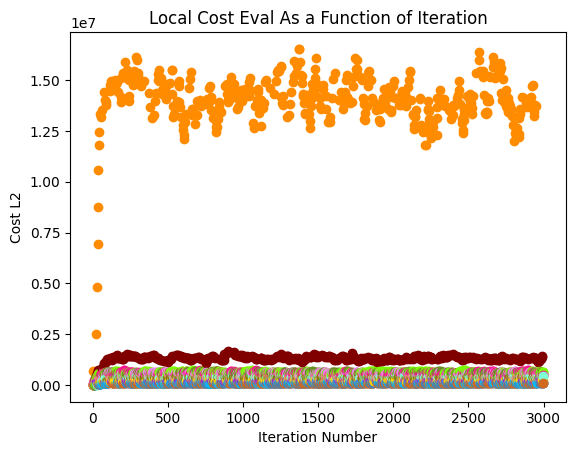

In [43]:
for i in range(big_loop_iters):
    if i%(big_loop_iters*.1)==0:
        print(f"Iter {i}")
    for (client_id, error) in global_model1.local_error_log[i]:
        plt.scatter(i, error, color=id2color[client_id])
        
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Local Cost Eval As a Function of Iteration')
#plt.xticks(np.arange(0, big_loop_iters+1, 1))
#plt.ylim(0, 80000)
plt.show()

Iter 0
Iter 300
Iter 600
Iter 900
Iter 1200
Iter 1500
Iter 1800
Iter 2100
Iter 2400
Iter 2700


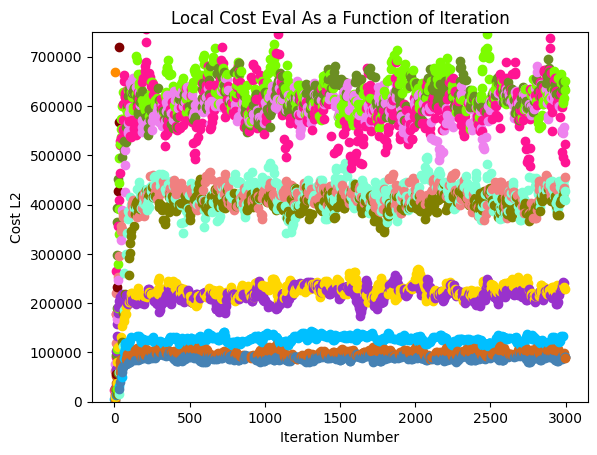

In [45]:
for i in range(big_loop_iters):
    if i%(big_loop_iters*.1)==0:
        print(f"Iter {i}")
    for (client_id, error) in global_model1.local_error_log[i]:
        plt.scatter(i, error, color=id2color[client_id])
        
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Local Cost Eval As a Function of Iteration')
plt.ylim(0, 750000)
plt.show()

Global

Iter 0
Iter 300
Iter 600
Iter 900
Iter 1200
Iter 1500
Iter 1800
Iter 2100
Iter 2400
Iter 2700


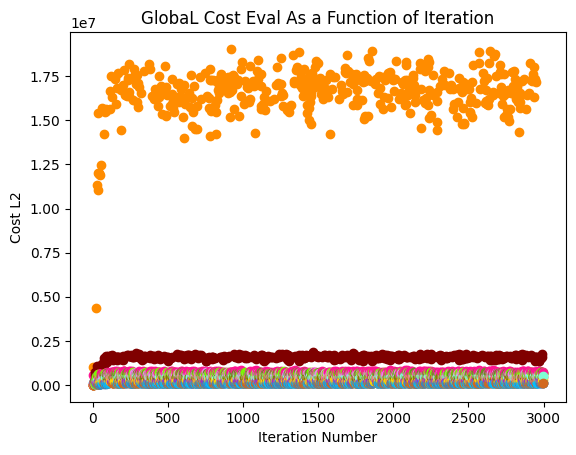

In [46]:
for i in range(big_loop_iters):
    if i%(big_loop_iters*.1)==0:
        print(f"Iter {i}")
    for (client_id, error) in global_model1.global_error_log[i]:
        plt.scatter(i, error, color=id2color[client_id])
        
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('GlobaL Cost Eval As a Function of Iteration')
#plt.xticks(np.arange(0, big_loop_iters+1, 1))
#plt.ylim(0, 80000)
plt.show()

## 10 Iters

In [ ]:
# ID, local_data, method, streaming=False, eta=1, num_steps=1, delay_scaling=5,
user_c0_10scipy = [client(i, cond0_dict_list[i], 'EtaScipyMinStep', num_steps=10, delay_scaling=0) for i in range(14)]

#ID, all_clients, D0
global_model2 = server(2, user_c0_10scipy, D_0)

for i in range(big_loop_iters):
    if i%(big_loop_iters*.1)==0:
        print(f"Iter {i}")
    global_model2.execute_FL_loop()
print("Complete")

## Varying Eta

In [ ]:
# ID, local_data, method, streaming=False, eta=1, num_steps=1, delay_scaling=5,
user_c0_eta10 = [client(i, cond0_dict_list[i], 'EtaGradStep', eta=10, delay_scaling=0) for i in range(14)]

#ID, all_clients, D0
global_model3 = server(3, user_c0_eta10, D_0)

for i in range(big_loop_iters):
    if i%(big_loop_iters*.1)==0:
        print(f"Iter {i}")
    global_model3.execute_FL_loop()
print("Complete")

## Full Scipy.Minimize

In [ ]:
# ID, local_data, method, streaming=False, eta=1, num_steps=1, delay_scaling=5,
user_c0_fullscipy = [client(i, cond0_dict_list[i], 'FullScipyMinStep', delay_scaling=0) for i in range(14)]

#ID, all_clients, D0
global_model4 = server(4, user_c0_fullscipy, D_0)

for i in range(big_loop_iters):
    if i%(big_loop_iters*.1)==0:
        print(f"Iter {i}")
    global_model4.execute_FL_loop()
print("Complete")